# Image Classification Using Pretrained Model (ResNet18)

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torchvision.transforms as transforms
from collections import Counter
import os

## Data Transforms and Augmentation

In [2]:
# # Define data transformations for data augmentation and normalization
# # https://pytorch.org/vision/0.9/transforms.html

# # Link: https://neptune.ai/blog/data-augmentation-in-python
# # Data augmentation is a technique that can be used to artificially
# # expand the size of a training set by creating modified data from the
# # existing one. It is a good practice to use DA if you want to prevent 
# # overfitting, or the initial dataset is too small to train on, or even 
# # if you want to squeeze better performance from your model.

# # Benefits of data augmenting:
# # 1. prevent overfitting
# # 2. improving the performance of the model 

# # Techniques of data augmentation used here (for images):
# # 1. geometric transformations: randomly flip, crop, rotate images 
# # 2. color space transformations: change RGB color channels

# transforms = {
#     'train': transforms.Compose([
#         # ADDED IN FROM https://pytorch.org/vision/0.9/transforms.html
    
#         # horizontally flip the image randomly with given probability
#         transforms.RandomHorizontalFlip(p=0.5),
#         # randomly resize and crop all the input images to 224 pixel size
#         transforms.RandomResizedCrop(size=(224, 224), antialias=True),
#         # rotate the image by angle
#         transforms.RandomRotation(degrees=90),
#         # randomly convert image to grayscale with probability of p
#         # (default 0.1)
#         transforms.RandomGrayscale(p=0.1),
#         # performs a random persepctive transformation of the image with
#         # given probability 
#         transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
#         # vertically flip the image randomly with given probability
#         transforms.RandomVerticalFlip(p=0.5),
#         # converting all the image data to a tensor BECAUSE PyTorch accepts
#         # the data in the form of tensor
#         # when image is transformed into PyTorch tensor, the pixel values 
#         # are scaled between 0.0 and 1.0
#         # converts the PIL image with a pixel range of [0, 255] to a PyTorch
#         # FloatTensor of shape (C, H, W) with range [0.0, 1.0]
#         # this is a MANDATORY step
#         transforms.ToTensor(),
#         # Link : https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
#         # normalizing images means transforming them into such values that
#         # the means and std dev of the image become 0.0 and 1.0 respectively
#         # normalization helps get data within a range and reduces the 
#         # skewness which helps learn faster and better, and can also tackle
#         # the diminishing and exploding gradients problem
#         # first parameter is the mean, second is the std
#         # the mean and std of ImageNet are: mean = [0.485, 0.465, 0.406]
#         # and std = [0.229, 0.224, 0.225]
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]),
#     # repeat steps from training data to testing (validation) data 
#     'test': transforms.Compose([    
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomResizedCrop(size=(224, 224), antialias=True),
#         transforms.RandomRotation(degrees=90),
#         transforms.RandomGrayscale(p=0.1),
#         transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]),
# }

# print(transforms)

############################################3333
# performing this augmentation allows us to provide a variety of different scenarios to a model so that our model will 
# learn to generalize in a better way

# Define data transformations for data augmentation and normalization
transforms = {
    'train': transforms.Compose([
        # randomly resize and crop all the input images to 224 pixel size
        transforms.RandomResizedCrop(224),
        # transform the images by horizontally flipping them
        transforms.RandomHorizontalFlip(p=0.5),
        # converting all the image data to a tensor BECAUSE PyTorch accepts the data in the form of tensor
        # this is a MANDATORY step
        transforms.ToTensor(),
        # normalizing the data so that our whole input data, training data can be on the same or similar scales
        # each array contains the RGB values (each value is a channel)
        # so we are working on colored images 
        # second array is performing standard deviation on it
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    # repeat steps from training data to testing (validation) data as well
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(transforms)


# # Define data transformations for data augmentation and normalization
# transforms = {
#         transforms.Compose([
#         # randomly resize and crop all the input images to 224 pixel size
#         transforms.RandomResizedCrop(224),
#         # transform the images by horizontally flipping them
#         transforms.RandomHorizontalFlip(p=0.5),
#         # converting all the image data to a tensor BECAUSE PyTorch accepts the data in the form of tensor
#         # this is a MANDATORY step
#         transforms.ToTensor(),
#         # normalizing the data so that our whole input data, training data can be on the same or similar scales
#         # each array contains the RGB values (each value is a channel)
#         # so we are working on colored images 
#         # second array is performing standard deviation on it
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
# }

# print(transforms)



{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


## Define Data Directory

In [3]:
# Define the data directory
# image_classification notebook is in the same source/repos directory in local and Jupyter Notebook directory
# this Notebook has to be in the same location as the dataset folder
dataset_directory = 'dataset'

# # Create data loaders
# # data loaders are responsible to load the data so we are loading the training and testing data 
# # inside dataset folder, there are two folders called train and test containing all the folders of the images
# datasets_images = {img: datasets.ImageFolder(os.path.join(dataset_directory, img), transforms[img]) 
#                    for img in dataset_directory}

# print(datasets_images)

# torch.utils.data.random_split(dataset, lengths)


# Create data loaders
# data loaders are responsible to load the data so we are loading the training and testing data 
# inside dataset folder, there are two folders called train and test containing all the folders of the images
dataset_imgs = datasets.ImageFolder(
                              root = 'dataset',
                              transform = transforms["train"]
                       )
print(dataset_imgs)

Dataset ImageFolder
    Number of datapoints: 700
    Root location: dataset
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
# Link: https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/

# class to index mapping
print(dataset_imgs.class_to_idx)

# {'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}

# index to class mapping : reverse of class to index mapping
idx_to_class = {v: k for k, v in dataset_imgs.class_to_idx.items()}
print(idx_to_class) # {0: 'airplane', 1: 'car', 2: 'cat', 3: 'dog', 4: 'flower', 5: 'fruit', 6: 'motorbike', 7: 'person'}

{'d': 0, 'e': 1, 'h': 2, 'l': 3, 'o': 4, 'r': 5, 'w': 6}
{0: 'd', 1: 'e', 2: 'h', 3: 'l', 4: 'o', 5: 'r', 6: 'w'}


In [5]:
# Link: https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/

def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dataset_imgs.class_to_idx.items()} # initialise dictionary
    
    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1
            
    return count_dict

print("Distribution of classes: ", get_class_distribution(dataset_imgs))


Distribution of classes:  {'d': 100, 'e': 100, 'h': 100, 'l': 100, 'o': 100, 'r': 100, 'w': 100}


In [7]:
train_percent = int(len(dataset_imgs)*0.6)
val_percent = int(len(dataset_imgs)*0.2)
test_percent = int(len(dataset_imgs)*0.2)
train_dataset, val_dataset, test_dataset = random_split(dataset_imgs, (train_percent, val_percent, test_percent))
print(len(dataset_imgs)) # length of the dataset
print(len(train_dataset)) # length of the train division
print(len(val_dataset)) # length of the validation division
print(len(test_dataset)) # length of the test division

# 700
# 420
# 140
# 140

700
420
140
140


## Define Dataloaders

In [8]:
# Link: https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/

# # first parameter: training_data
# # shuffle means while training the data it will shuffle the data
# # num_workers means parallelizing the process (4 different processes can work at the same time)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=4, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=4)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=4)

# length of dataloader = overall dataset len / batch size
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

# Length of the train_loader: 105
# Length of the val_loader: 35
# Length of the test_loader: 35


Length of the train_loader: 105
Length of the val_loader: 35
Length of the test_loader: 35


## Create the Model 

In [10]:
# Load the pre-trained ResNet-18 network trained on the ImageNet dataset
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer and then fine tune
# this model on our custom data set to detect whether the given image to a
# model is what letter
# freezing all layers except the final classification layers which is 
# responsible for performing classfication
# this for loop line specifically: return an iterator over module parameters,
# yielding both the name of the parameter as well as the parameter itself
# only the last layer is optimized, the rest will be frozen (base parameters
# will receive no gradients - they have requires_grad=False)
for name, param in model.named_parameters():
    # if the paramater contains this FC (FC means fully connected layer), then set the required grads equal to 
    # true
    if "fc" in name:  
        # Unfreeze the final classification layer
        # to achieve best results, we fine-tune the later layers in the network
        # later, will replace the last layer
        param.requires_grad = True
    # if FC is not in the parameter, then set the required grads equal to false
    else:
        # freezes the layers and prevents PyTorch from calculating the gradients for these layers during
        # back propogations
        param.requires_grad = False
    # what happens is wherever fc parameter is present, all those layers will be trained because we are setting
    # the value true over there and wherever we have written false, all those layers will be freeze. this is how
    # we freeze all the layers and we can only fine tune the final layer

# Define the loss function and optimizer
# whenever working on image classification, this is most commonly method to calculate loss. 
criterion = nn.CrossEntropyLoss()
# optimizer is a stochastic gradient descent optimizer (lr is learning range and momentum)
# CAN CHANGE THESE VALUES to test how the model performs
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# sending all the models here to device
model = model.to(device)


C:\Users\emily\Anaconda2024\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\emily\Anaconda2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train the Model

In [17]:
# Training loop

# garbage collector
import gc

num_epochs = 10

for epoch in range(num_epochs):

    running_loss = 0.0
    running_correct = 0
    total = 0

    ## TRAIN SET
    for inputs, labels in train_loader:
        # inputs means the image 
        # all being sent to device because the model is on the device (CPU/GPU)
        inputs = inputs.to(device)
        # labels means the output label (the class name)
        labels = labels.to(device)
        # clear the gradients from the previous iterations 
        optimizer.zero_grad()
        

        with torch.set_grad_enabled(True):
            # if phase is train, then we are using the model to make predictions 
            # and providing the inputs which are the images 
            # prediction of the model is stored in outputs
            # "outputs" is the predictions of the model and "labels" is the actual labels
            outputs = model(inputs)
            # so we are comparing the output label and our current label, on the basis
            # of that we are getting the loss value
            loss = criterion(outputs, labels)
            # this line is responsible for showing you the predictions 
            _, preds = torch.max(outputs, 1)
            # if the phase is train, we perform backward pass
            if train_loader:
                # backward pass: calculating the gradients
                loss.backward()
                # and then updating the weights on the basis of calculated gradients 
                optimizer.step()


        # storing all the losses and all the correct predictions 
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)


    # these two lines help you to see the epoch loss and epoch accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_correct.double() / len(train_dataset)
    print ('Epoch [{}/{}], TRAIN Loss: {:.4f}, Acc: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))
    
    # delete and garbage collect
    del inputs, labels, outputs
    gc.collect()
    

    # TEST SET
    with torch.no_grad():
        
        # reinitialize 
        running_loss = 0.0
        running_correct = 0
        total = 0
        
        for inputs, labels in test_loader:
            # inputs means the image 
            # all being sent to device because the model is on the device (CPU/GPU)
            inputs = inputs.to(device)
            # labels means the output label (the class name)
            labels = labels.to(device)
            # clear the gradients from the previous iterations 
            optimizer.zero_grad()
            # prediction of the model is stored in outputs
            # "outputs" is the predictions of the model and "labels" is the actual labels
            outputs = model(inputs)
            # this line is responsible for showing you the predictions 
            _, preds = torch.max(outputs, 1) 
            # so we are comparing the output label and our current label, on the basis
            # of that we are getting the loss value
            loss = criterion(outputs, labels)
            
            # storing all the losses and all the correct predictions 
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            running_correct += torch.sum(preds == labels.data)

        # these two lines helping you to see the epoch loss and epoch accuracy
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_correct.double() / len(test_dataset)

        print ('Epoch [{}/{}], TEST Loss: {:.4f}, Acc: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))
        print('Accuracy of the network on the {} validation images: {} %'.format(140, 100 * running_correct / total))
        
        # delete and garbage collect
        del inputs, labels, outputs
        gc.collect()

print("Training complete!")



Epoch [1/10], TRAIN Loss: 1.2355, Acc: 0.5833
Epoch [1/10], TEST Loss: 4.7795, Acc: 0.6143
Accuracy of the network on the 140 validation images: 61.42856979370117 %
Epoch [2/10], TRAIN Loss: 1.1256, Acc: 0.6024
Epoch [2/10], TEST Loss: 4.4416, Acc: 0.6286
Accuracy of the network on the 140 validation images: 62.85714340209961 %
Epoch [3/10], TRAIN Loss: 1.2079, Acc: 0.5881
Epoch [3/10], TEST Loss: 4.7136, Acc: 0.6357
Accuracy of the network on the 140 validation images: 63.57143020629883 %
Epoch [4/10], TRAIN Loss: 1.1896, Acc: 0.5810
Epoch [4/10], TEST Loss: 4.5194, Acc: 0.6786
Accuracy of the network on the 140 validation images: 67.85713958740234 %
Epoch [5/10], TRAIN Loss: 1.1079, Acc: 0.6190
Epoch [5/10], TEST Loss: 4.4082, Acc: 0.6643
Accuracy of the network on the 140 validation images: 66.42857360839844 %
Epoch [6/10], TRAIN Loss: 1.2994, Acc: 0.5762
Epoch [6/10], TEST Loss: 5.0137, Acc: 0.6357
Accuracy of the network on the 140 validation images: 63.57143020629883 %
Epoch [7/1

In [18]:
# Save the model
torch.save(model.state_dict(), 'letter_classification_model.pth')

## Perform Classification on Unseen Images

To classify unseen images, the model is loaded in and applied to unseen images from the internet.

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
# the pretrained model is trained on imageNet dataset with a thousand classes 
# freezing all the layers except for the last layer means we are using transfer learning which
# means the model is already trained on some data 
# that means this model is ready to extract the features so we can use that knowledge from the 
# pretrained model to extract the feature and in the final layer we are only using the two 
# neurons which are responsible for telling us what letter class it is

# replacing the last layer to adapt the model to a new problem with a different number of output
# classes
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('letter_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
# 7 for the number of classes
new_model.fc = nn.Linear(new_model.fc.in_features, 7)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

Load in unseen image to prepare to perform inference using the model.

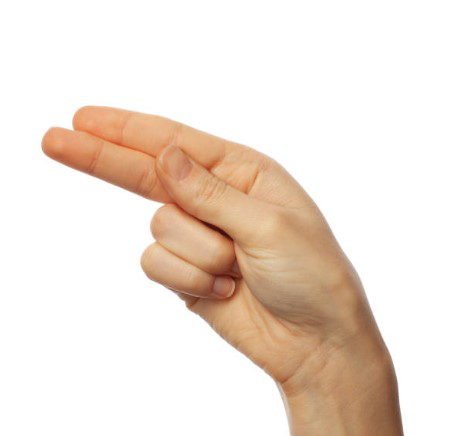

In [30]:
# Load and preprocess the unseen image
image_path = 'h_sign_lang.jpg'  # Replace with the path to your image
image = Image.open(image_path)
display(image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# all these tasks are in preprocess variable
# in preprocess, we want to preprocess the image
preprocessed_unseen = preprocess(image)
# adding a batch dimension
batch_unseen = preprocessed_unseen.unsqueeze(0)  


Perform inference of the gesture "h":

In [22]:
# Perform inference
with torch.no_grad():
    # providing the input with input_batch
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['d', 'e', 'h', 'l', 'o', 'r', 'w']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: h


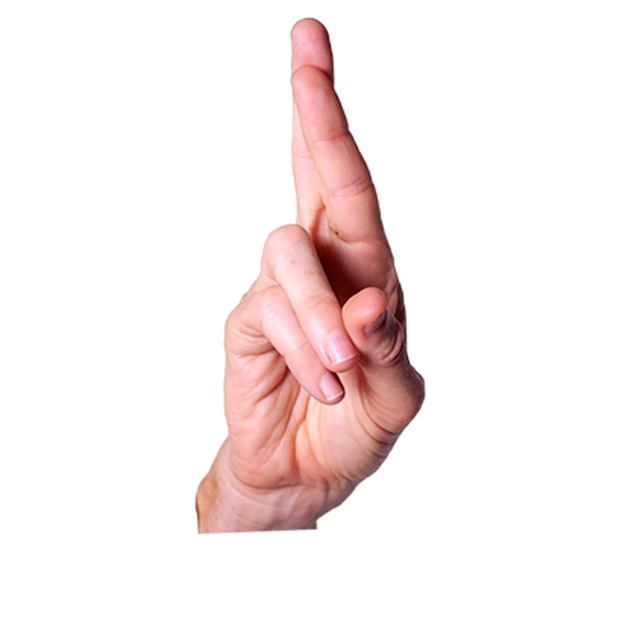

In [28]:
# Load and preprocess the unseen image
image_path = 'r_sign_lang.jpg'  # Replace with the path to your image
image = Image.open(image_path)
display(image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# all these tasks are in preprocess variable
# in preprocess, we want to preprocess the image
preprocessed_unseen = preprocess(image)
# adding a batch dimension
batch_unseen = preprocessed_unseen.unsqueeze(0)  


Perform inference of the gesture "r":

In [24]:
# Perform inference
with torch.no_grad():
    # providing the input with input_batch
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['d', 'e', 'h', 'l', 'o', 'r', 'w']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: r


## Example of a Wrongly Predicted Letter 

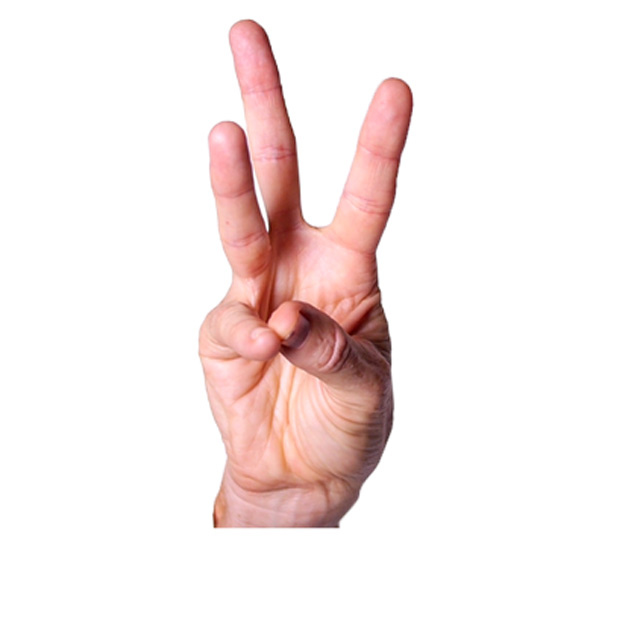

In [25]:
# Load and preprocess the unseen image
image_path = 'w_sign_lang.jpg'  # Replace with the path to your image
image = Image.open(image_path)
display(image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# all these tasks are in preprocess variable
# in preprocess, we want to preprocess the image
preprocessed_unseen = preprocess(image)
# adding a batch dimension
batch_unseen = preprocessed_unseen.unsqueeze(0)  

Perform inference of the gesture "w":

In [26]:
# Perform inference
with torch.no_grad():
    # providing the input with input_batch
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['d', 'e', 'h', 'l', 'o', 'r', 'w']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: r
